In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/top-1000-instagrammers-world-cleaned/top_1000_instagrammers.csv


# introduction

Instagram[a] is a photo and video sharing social networking service founded in 2010 by Kevin Systrom and Mike Krieger, and later acquired by American company Facebook Inc. The app allows users to upload media that can be edited with filters and organized by hashtags and geographical tagging. Posts can be shared publicly or with preapproved followers. Users can browse other users' content by tag and location, view trending content, like photos, and follow other users to add their content to a personal feed.

This dataset comprises of the details of top 1000 influencers in instagram

To be able to find commonalities among more than 100M accounts and use these characteristics to predict the number of followers of other accounts

in the end, I willAnswer the following questions for all of the models:

**Is the relationship significant?**

**Are any model assumptions violated?**

**Is there any multicollinearity in the model?**

**In the multivariate models are predictor variables independent of all the other predictor variables?**

**In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.**

**Does the model make sense?**

**Does regularization help?**

**Which independent variables are significant?**

**Which hyperparameters are important?**

## Start up the H2O Cluster

In [2]:
# Load the H2O library and start up the H2O cluter locally on your machine
import h2o

# Number of threads, nthreads = -1, means use all cores on your machine
# max_mem_size is the maximum memory (in GB) to allocate to H2O
h2o.init(nthreads = -1, max_mem_size = 8)

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.16" 2022-07-19; OpenJDK Runtime Environment (build 11.0.16+8-post-Ubuntu-0ubuntu120.04); OpenJDK 64-Bit Server VM (build 11.0.16+8-post-Ubuntu-0ubuntu120.04, mixed mode, sharing)
  Starting server from /opt/conda/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpdcar2bt1
  JVM stdout: /tmp/tmpdcar2bt1/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpdcar2bt1/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.1
H2O_cluster_version_age:,1 month and 17 days
H2O_cluster_name:,H2O_from_python_unknownUser_lfxrnf
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


## Dataset

In [3]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

df = pd.read_csv("../input/top-1000-instagrammers-world-cleaned/top_1000_instagrammers.csv")
df.columns = [c.replace(' ', '_') for c in df.columns]
df.columns = [c.replace('.', '') for c in df.columns]
df.head()

,Name,Rank,Category,Followers,Audience_Country,Authentic_Engagement,Engagement_Avg
0,cristiano,1,Sports with a ball,462.9M,India,5.5M,6.6M
1,leomessi,2,Sports with a ballFamily,347.2M,Argentina,3.6M,4.8M
2,kendalljenner,3,ModelingFashion,247.6M,United States,3M,4.9M
3,arianagrande,4,Music,321.4M,United States,2.4M,3.4M
4,zendaya,5,Cinema & Actors/actressesFashion,147M,United States,4.3M,5.8M


In [4]:
df.shape

(1000, 7)

## Data process

In [5]:
from numpy import nan
import logging 
# transfer string to float
colums = ["Followers","Authentic_Engagement","Engagement_Avg"]    
content_list=[]
for label,content in df.items():
    if(label in colums):
        content = content.replace({"K":"*1e3", "M":"*1e6"}, regex=True).map(pd.eval).astype(float)
        content_list.append(content)
df = df.assign(Followers= content_list[0],Authentic_Engagement= content_list[1],Engagement_Avg= content_list[2])


In [6]:
df.head()

,Name,Rank,Category,Followers,Audience_Country,Authentic_Engagement,Engagement_Avg
0,cristiano,1,Sports with a ball,462900000.0,India,5500000.0,6600000.0
1,leomessi,2,Sports with a ballFamily,347200000.0,Argentina,3600000.0,4800000.0
2,kendalljenner,3,ModelingFashion,247600000.0,United States,3000000.0,4900000.0
3,arianagrande,4,Music,321400000.0,United States,2400000.0,3400000.0
4,zendaya,5,Cinema & Actors/actressesFashion,147000000.0,United States,4300000.0,5800000.0


In [7]:
df_dummy = pd.get_dummies(df,columns= ['Category','Audience_Country'])
df_dummy.head()

,Name,Rank,Followers,Authentic_Engagement,Engagement_Avg,Category_Adult content,Category_Animals,Category_Art/Artists,Category_Art/ArtistsBeauty,Category_Art/ArtistsCinema & Actors/actresses,...,Audience_Country_Russia,Audience_Country_Senegal,Audience_Country_South Korea,Audience_Country_Spain,Audience_Country_Syria,Audience_Country_Thailand,Audience_Country_Turkey,Audience_Country_United Arab Emirates,Audience_Country_United Kingdom,Audience_Country_United States
0,cristiano,1,462900000.0,5500000.0,6600000.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,leomessi,2,347200000.0,3600000.0,4800000.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,kendalljenner,3,247600000.0,3000000.0,4900000.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,arianagrande,4,321400000.0,2400000.0,3400000.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,zendaya,5,147000000.0,4300000.0,5800000.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [8]:
#Using OLS for finding the p value to check the significant features
import statsmodels.api as sm

model = sm.OLS(df['Followers'], df_dummy[['Rank',
       'Authentic_Engagement','Engagement_Avg','Audience_Country_United States','Category_Music']]).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:              Followers   R-squared (uncentered):                   0.268
Model:                            OLS   Adj. R-squared (uncentered):              0.264
Method:                 Least Squares   F-statistic:                              72.79
Date:                Sat, 05 Nov 2022   Prob (F-statistic):                    5.24e-65
Time:                        17:39:17   Log-Likelihood:                         -19014.
No. Observations:                1000   AIC:                                  3.804e+04
Df Residuals:                     995   BIC:                                  3.806e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Rank                            3217.3064   2793.779      1.152      0.250   -2265.069    8699.682
Authentic_Engagement             -13.8679      5.532     -2.507      0.012     -24.724      -3.012
Engagement_Avg                    25.1721      4.803      5.241      0.000      15.747      34.597
Audience_Country_United States  1.657e+07   3.11e+06      5.326      0.000    1.05e+07    2.27e+07
Category_Music                  1.165e+07   3.66e+06      3.185      0.001    4.47e+06    1.88e+07
==============================================================================
Omnibus:                     1035.518   Durbin-Watson:                   1.392
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            63344.747
Skew:                           4.884   Prob(JB):                         0.00
Kurtosis:                      40.747   Cond. No.                     4.66e+06
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.66e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## add new colum :Followers>100M

In [9]:
list_temp = []
for label,content in df.items():
    if(label !='Followers'): continue
    for obj in content:
        if(obj>100000000.0):
            list_temp.append(1)
        else:
            list_temp.append(0)

df = df.assign(FollowersBigger100M=list_temp)

In [10]:
df.eval('Authentic_Engagement =Authentic_Engagement/Followers',inplace= True) 
df.eval('Engagement_Avg =Engagement_Avg/Followers',inplace= True) 

In [11]:
df.head()

,Name,Rank,Category,Followers,Audience_Country,Authentic_Engagement,Engagement_Avg,FollowersBigger100M
0,cristiano,1,Sports with a ball,462900000.0,India,0.011882,0.014258,1
1,leomessi,2,Sports with a ballFamily,347200000.0,Argentina,0.010369,0.013825,1
2,kendalljenner,3,ModelingFashion,247600000.0,United States,0.012116,0.019790,1
3,arianagrande,4,Music,321400000.0,United States,0.007467,0.010579,1
4,zendaya,5,Cinema & Actors/actressesFashion,147000000.0,United States,0.029252,0.039456,1


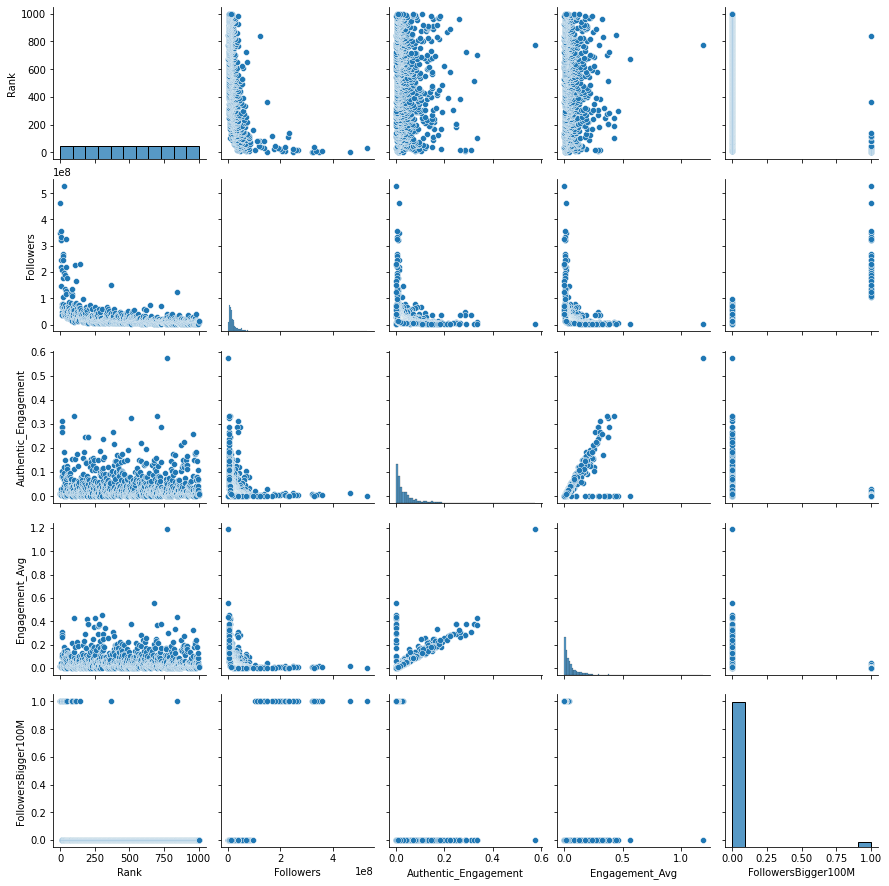

In [12]:
#pair plot to check the colinearity
sns.pairplot(df) 

From the pair plot and heat map, we can see that Authentic_Engagement and Engagement_Avg are corelated each other. 

In [13]:
df_dummy = pd.get_dummies(df,columns= ['Category','Audience_Country'])
df_dummy.head()

,Name,Rank,Followers,Authentic_Engagement,Engagement_Avg,FollowersBigger100M,Category_Adult content,Category_Animals,Category_Art/Artists,Category_Art/ArtistsBeauty,...,Audience_Country_Russia,Audience_Country_Senegal,Audience_Country_South Korea,Audience_Country_Spain,Audience_Country_Syria,Audience_Country_Thailand,Audience_Country_Turkey,Audience_Country_United Arab Emirates,Audience_Country_United Kingdom,Audience_Country_United States
0,cristiano,1,462900000.0,0.011882,0.014258,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,leomessi,2,347200000.0,0.010369,0.013825,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,kendalljenner,3,247600000.0,0.012116,0.019790,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,arianagrande,4,321400000.0,0.007467,0.010579,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,zendaya,5,147000000.0,0.029252,0.039456,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [14]:
#Using OLS for finding the p value to check the significant features
import statsmodels.api as sm

model = sm.OLS(df['FollowersBigger100M'], df_dummy[['Rank',
       'Authentic_Engagement','Engagement_Avg','Followers','Audience_Country_United States','Category_Music']]).fit()

# Print out the statistics
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     FollowersBigger100M   R-squared (uncentered):                   0.676
Model:                             OLS   Adj. R-squared (uncentered):              0.674
Method:                  Least Squares   F-statistic:                              345.4
Date:                 Sat, 05 Nov 2022   Prob (F-statistic):                   4.10e-239
Time:                         17:39:22   Log-Likelihood:                          849.92
No. Observations:                 1000   AIC:                                     -1688.
Df Residuals:                      994   BIC:                                     -1658.
Df Model:                            6                                                  
Covariance Type:             nonrobust                                                  
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Rank                           -6.031e-05   7.25e-06     -8.319      0.000   -7.45e-05   -4.61e-05
Authentic_Engagement              -0.1429      0.104     -1.372      0.170      -0.347       0.061
Engagement_Avg                     0.0438      0.068      0.645      0.519      -0.089       0.177
Followers                       3.002e-09   6.99e-11     42.956      0.000    2.86e-09    3.14e-09
Audience_Country_United States     0.0128      0.007      1.740      0.082      -0.002       0.027
Category_Music                    -0.0103      0.009     -1.191      0.234      -0.027       0.007
==============================================================================
Omnibus:                      694.564   Durbin-Watson:                   1.680
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16313.660
Skew:                           2.850   Prob(JB):                         0.00
Kurtosis:                      21.948   Cond. No.                     1.87e+09
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.87e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Encode response variable
Since we want to train a binary classification model, we must ensure that the response is coded as a factor. 

In [15]:
#create h2oframe using pandas dataframe
hf = h2o.H2OFrame(df)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [16]:
hf['FollowersBigger100M'] = hf['FollowersBigger100M'].asfactor()  #encode the binary repsonse as a factor
hf['FollowersBigger100M'].levels()

[['0', '1']]

## partition data

In [17]:
# Partition data into 70%, 15%, 15% chunks
# Setting a seed will guarantee reproducibility

splits = hf.split_frame(ratios=[0.7, 0.15], seed=1)  

train = splits[0]
valid = splits[1]
test = splits[2]

In [18]:
print(train.nrow)
print(valid.nrow)
print(test.nrow)


699
150
151


## Identify response and predictor variables

In [19]:
y = 'FollowersBigger100M'
x = hf.columns


In [20]:
x.remove(y)  #remove the response
x.remove('Rank')
x.remove('Followers') 
x.remove('Engagement_Avg') #remove the  column because it's correlated with the outcome

In [21]:
x

['Name', 'Category', 'Audience_Country', 'Authentic_Engagement']

# H2O Machine Learning 

Now that we have prepared the data, we can train some models. We will start by training a single model from each of the H2O supervised algos:

    Generalized Linear Model (GLM)
    Automatic Machine Learning（AutoML）


## 1. Generalized Linear Model

In [22]:
# Import H2O GLM:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator

In [23]:
# Initialize the GLM estimator:
# Similar to R's glm() and H2O's R GLM, H2O's GLM has the "family" argument

glm_fit1 = H2OGeneralizedLinearEstimator(family='binomial', model_id='glm_fit1')

In [24]:
# training model
glm_fit1.train(x=x, y=y, training_frame=train)

glm Model Build progress: |

/opt/conda/lib/python3.7/site-packages/h2o/estimators/estimator_base.py:193: RuntimeWarning: Dropping bad and constant columns: [Name]
  warnings.warn(mesg["message"], RuntimeWarning)


██████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: glm_fit1


GLM Model: summary
    family    link    regularization                                 number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  ------  ---------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------
    binomial  logit   Elastic Net (alpha = 0.5, lambda = 0.004955 )  189                           4                              7                       py_5_sid_9c46

ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.030837509318758713
RMSE: 0.17560611982148774
LogLoss: 0.11841262805084014
AUC: 0.9088130563798219
AUCPR: 0.3925992244037537
Gini: 0.8176261127596438
Null degrees of freedom: 698
Residual degrees of freedom: 694
Null deviance: 215.63375688966926
Residual deviance: 165.54085401507453
AIC: 175.54085401507453

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.12056257499844952
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      655  19   0.0282   (19.0/674.0)
1      10   15   0.4      (10.0/25.0)
Total  665  34   0.0415   (29.0/699.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.120563     0.508475  26
max f2                       0.108431     0.592105  41
max f0point5                 0.120563     0.465839  26
max accuracy                 0.141618     0.968526  4
max precision                0.148747     1         0
max recall                   0.0316308    1         200
max specificity              0.148747     1         0
max absolute_mcc             0.117164     0.497454  30
max min_per_class_accuracy   0.0444913    0.795252  127
max mean_per_class_accuracy  0.108431     0.834777  41
max tns                      0.148747     674       0
max fns                      0.148747     24        0
max fps                      1.02535e-05  674       399
max tps                      0.0316308    25        200
max tnr                      0.148747     1         0
max fnr                      0.148747     0.96      0
max fpr                      1.02535e-05  1         399
max tpr                      0.0316308    1         200

Gains/Lift Table: Avg response rate:  3.58 %, avg score:  3.58 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0157368                   0.135416           10.1673   10.1673            0.363636         0.139855     0.363636                    0.139855            0.16            0.16                       916.727   916.727            0.149614
2        0.0200286                   0.133609           18.64     11.9829            0.666667         0.134198     0.428571                    0.138643            0.08            0.24                       1764      1098.29            0.228131
3        0.0300429                   0.128037           7.98857   10.6514            0.285714         0.131663     0.380952                    0.136316            0.08            0.32                       698.857   965.143            0.300712
4        0.0400572                   0.123479           7.98857   9.98571            0.285714         0.125722     0.357143                    0.133668            0.08            0.4                        698.857   898.571            0.373294
5       

In [25]:
print(glm_fit1.model_performance(test))

ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.019059767797649944
RMSE: 0.13805711788115071
LogLoss: 0.08607062748207153
AUC: 0.8806306306306307
AUCPR: 0.07645123769839368
Gini: 0.7612612612612615
Null degrees of freedom: 150
Residual degrees of freedom: 146
Null deviance: 30.765156375358604
Residual deviance: 25.993329499585602
AIC: 35.9933294995856

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.11532226447887438
       0    1    Error    Rate
-----  ---  ---  -------  -----------
0      142  6    0.0405   (6.0/148.0)
1      2    1    0.6667   (2.0/3.0)
Total  144  7    0.053    (8.0/151.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.115322     0.2       4
max f2                       0.0519179    0.357143  27
max f0point5                 0.115322     0.16129   4
max accuracy                 0.

# 2. Generalized AutoML Model

In [26]:
# Import automl:
from h2o.automl import H2OAutoML

In [27]:
#create automl model
aml = H2OAutoML(max_models=10, seed=1)

In [28]:
#training model
aml.train(x=x, y=y, training_frame=train)


AutoML progress: |
17:39:27.796: _train param, Dropping bad and constant columns: [Name]

█
17:39:31.146: _train param, Dropping bad and constant columns: [Name]

█
17:39:33.34: _train param, Dropping bad and constant columns: [Name]

█
17:39:35.573: _train param, Dropping bad and constant columns: [Name]

█
17:39:37.199: _train param, Dropping bad and constant columns: [Name]

█
17:39:38.877: _train param, Dropping bad and constant columns: [Name]

█
17:39:40.264: _train param, Dropping bad and constant columns: [Name]

██
17:39:42.63: _train param, Dropping bad and constant columns: [Name]
17:39:43.197: _train param, Dropping bad and constant columns: [Name]

█
17:39:44.903: _train param, Dropping bad and constant columns: [Name]

██
17:39:47.577: _train param, Dropping unused columns: [Name]

██████
17:39:52.692: _train param, Dropping unused columns: [Name]

██████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_1_AutoML_1_20221105_173927

No summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.01603835834710227
RMSE: 0.12664264031953168
LogLoss: 0.06053677385385726
AUC: 0.983560830860534
AUCPR: 0.8013312383030488
Gini: 0.9671216617210681
Null degrees of freedom: 698
Residual degrees of freedom: 694
Null deviance: 215.63375688966926
Residual deviance: 84.63040984769246
AIC: 94.63040984769246

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34392644833842095
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      667  7    0.0104   (7.0/674.0)
1      5    20   0.2      (5.0/25.0)
Total  672  27   0.0172   (12.0/699.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.343926     0.769231  26
max f2                       0.343926     0.787402  26
max f0point5                 0.639272     0.797101  10
max accuracy                 0.369445     0.984263  21
max precision                0.732343     1         0
max recall                   0.04063      1         117
max specificity              0.732343     1         0
max absolute_mcc             0.343926     0.760936  26
max min_per_class_accuracy   0.133821     0.92      49
max mean_per_class_accuracy  0.133821     0.93997   49
max tns                      0.732343     674       0
max fns                      0.732343     24        0
max fps                      8.30485e-05  674       399
max tps                      0.04063      25        117
max tnr                      0.732343     1         0
max fnr                      0.732343     0.96      0
max fpr                      8.30485e-05  1         399
max tpr                      0.04063      1         117

Gains/Lift Table: Avg response rate:  3.58 %, avg score:  4.07 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100143                   0.652134           27.96     27.96              1                0.708235     1                           0.708235            0.28            0.28                       2696      2696               0.28
2        0.0200286                   0.537547           15.9771   21.9686            0.571429         0.609548     0.785714                    0.658892            0.16            0.44                       1497.71   2096.86            0.435549
3        0.0300429                   0.369473           23.9657   22.6343            0.857143         0.437889     0.809524                    0.585224            0.24            0.68                       2296.57   2163.43            0.674065
4        0.0400572                   0.339243           11.9829   19.9714            0.428571         0.35443      0.714286                    0.527525            0.12            0.8                        1098.29   1897.14            0.788131
5        0.0500715                   0.239126           0         15.9771            0                0.290099     0.571429                    0.48004             0               0.8                        -100      1497.71            0.777745
6        0.100143                    0.0904162          2.39657   9.18686            0.0857143        0.138989     0.328571                    0.309514            0.12            0.92                       139.657   818.686       

In [29]:
lb = aml.leaderboard
lb.head(rows=lb.nrows) 

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_1_AutoML_1_20221105_173927,0.913769,0.101512,0.333943,0.197804,0.165662,0.0274438
GBM_1_AutoML_1_20221105_173927,0.908991,0.10494,0.31479,0.238546,0.168305,0.0283267
XGBoost_3_AutoML_1_20221105_173927,0.90635,0.102603,0.291405,0.24816,0.166875,0.0278471
GLM_1_AutoML_1_20221105_173927,0.897567,0.108069,0.295052,0.22003,0.16935,0.0286795
XGBoost_2_AutoML_1_20221105_173927,0.893323,0.108503,0.288932,0.228902,0.170764,0.0291605
StackedEnsemble_AllModels_1_AutoML_1_20221105_173927,0.882255,0.108159,0.315428,0.193353,0.166493,0.0277199
GBM_2_AutoML_1_20221105_173927,0.842018,0.127244,0.28181,0.349644,0.174147,0.0303273
GBM_3_AutoML_1_20221105_173927,0.838902,0.131698,0.209759,0.33632,0.178017,0.0316901
XRT_1_AutoML_1_20221105_173927,0.838427,0.129905,0.162792,0.33632,0.179498,0.0322196
DRF_1_AutoML_1_20221105_173927,0.822789,0.246366,0.245204,0.260772,0.174081,0.030304


In [30]:
# Print model performance
# view leaderboard
lb = aml.leaderboard
lb

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_1_AutoML_1_20221105_173927,0.913769,0.101512,0.333943,0.197804,0.165662,0.0274438
GBM_1_AutoML_1_20221105_173927,0.908991,0.10494,0.31479,0.238546,0.168305,0.0283267
XGBoost_3_AutoML_1_20221105_173927,0.90635,0.102603,0.291405,0.24816,0.166875,0.0278471
GLM_1_AutoML_1_20221105_173927,0.897567,0.108069,0.295052,0.22003,0.16935,0.0286795
XGBoost_2_AutoML_1_20221105_173927,0.893323,0.108503,0.288932,0.228902,0.170764,0.0291605
StackedEnsemble_AllModels_1_AutoML_1_20221105_173927,0.882255,0.108159,0.315428,0.193353,0.166493,0.0277199
GBM_2_AutoML_1_20221105_173927,0.842018,0.127244,0.28181,0.349644,0.174147,0.0303273
GBM_3_AutoML_1_20221105_173927,0.838902,0.131698,0.209759,0.33632,0.178017,0.0316901
XRT_1_AutoML_1_20221105_173927,0.838427,0.129905,0.162792,0.33632,0.179498,0.0322196
DRF_1_AutoML_1_20221105_173927,0.822789,0.246366,0.245204,0.260772,0.174081,0.030304


In [31]:
# To generate predictions on a test set, you can make predictions
preds = aml.predict(test)
preds

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict,p0,p1
0,0.999737,0.000262742
0,0.979631,0.0203687
1,0.809199,0.190801
0,0.999841,0.000159371
0,0.984416,0.0155838
0,0.999757,0.000243061
0,0.998568,0.00143164
0,0.999587,0.000412874
0,0.999587,0.00041292
0,0.998027,0.00197262


In [32]:
# view best model 
best = aml.leader
best 

Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_1_AutoML_1_20221105_173927

No summary for this model

ModelMetricsBinomialGLM: stackedensemble
** Reported on train data. **

MSE: 0.01603835834710227
RMSE: 0.12664264031953168
LogLoss: 0.06053677385385726
AUC: 0.983560830860534
AUCPR: 0.8013312383030488
Gini: 0.9671216617210681
Null degrees of freedom: 698
Residual degrees of freedom: 694
Null deviance: 215.63375688966926
Residual deviance: 84.63040984769246
AIC: 94.63040984769246

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.34392644833842095
       0    1    Error    Rate
-----  ---  ---  -------  ------------
0      667  7    0.0104   (7.0/674.0)
1      5    20   0.2      (5.0/25.0)
Total  672  27   0.0172   (12.0/699.0)

Maximum Metrics: Maximum metrics at their respective thresholds
metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.343926     0.769231  26
max f2                       0.343926     0.787402  26
max f0point5                 0.639272     0.797101  10
max accuracy                 0.369445     0.984263  21
max precision                0.732343     1         0
max recall                   0.04063      1         117
max specificity              0.732343     1         0
max absolute_mcc             0.343926     0.760936  26
max min_per_class_accuracy   0.133821     0.92      49
max mean_per_class_accuracy  0.133821     0.93997   49
max tns                      0.732343     674       0
max fns                      0.732343     24        0
max fps                      8.30485e-05  674       399
max tps                      0.04063      25        117
max tnr                      0.732343     1         0
max fnr                      0.732343     0.96      0
max fpr                      8.30485e-05  1         399
max tpr                      0.04063      1         117

Gains/Lift Table: Avg response rate:  3.58 %, avg score:  4.07 %
group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain    kolmogorov_smirnov
-------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------  --------------------
1        0.0100143                   0.652134           27.96     27.96              1                0.708235     1                           0.708235            0.28            0.28                       2696      2696               0.28
2        0.0200286                   0.537547           15.9771   21.9686            0.571429         0.609548     0.785714                    0.658892            0.16            0.44                       1497.71   2096.86            0.435549
3        0.0300429                   0.369473           23.9657   22.6343            0.857143         0.437889     0.809524                    0.585224            0.24            0.68                       2296.57   2163.43            0.674065
4        0.0400572                   0.339243           11.9829   19.9714            0.428571         0.35443      0.714286                    0.527525            0.12            0.8                        1098.29   1897.14            0.788131
5        0.0500715                   0.239126           0         15.9771            0                0.290099     0.571429                    0.48004             0               0.8                        -100      1497.71            0.777745
6        0.100143                    0.0904162          2.39657   9.18686            0.0857143        0.138989     0.328571                    0.309514            0.12            0.92                       139.657   818.686       

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse,training_time_ms,predict_time_per_row_ms,algo
GLM_1_AutoML_1_20221105_173927,0.914414,0.0842035,0.113196,0.343468,0.152511,0.0232598,169,0.020602,GLM
GBM_4_AutoML_1_20221105_173927,0.903153,0.0817604,0.107013,0.343468,0.142159,0.0202091,96,0.028114,GBM
StackedEnsemble_BestOfFamily_1_AutoML_1_20221105_173927,0.896396,0.084908,0.10529,0.193694,0.149889,0.0224667,5044,0.080842,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20221105_173927,0.896396,0.084544,0.10529,0.193694,0.15003,0.022509,4385,0.067715,StackedEnsemble
XGBoost_1_AutoML_1_20221105_173927,0.890766,0.0929939,0.089237,0.350225,0.138203,0.0191001,161,0.019627,XGBoost
GBM_1_AutoML_1_20221105_173927,0.881757,0.0855086,0.0842493,0.210586,0.149968,0.0224903,253,0.034947,GBM
GBM_3_AutoML_1_20221105_173927,0.871622,0.0885628,0.0943654,0.346847,0.149442,0.022333,126,0.032434,GBM
XGBoost_2_AutoML_1_20221105_173927,0.869369,0.0861189,0.0689639,0.220721,0.146877,0.0215729,188,0.023128,XGBoost
XGBoost_3_AutoML_1_20221105_173927,0.851351,0.0907883,0.0724862,0.217342,0.148439,0.022034,193,0.025992,XGBoost
DRF_1_AutoML_1_20221105_173927,0.842342,0.106381,0.0578062,0.0878378,0.160195,0.0256624,142,0.106137,DRF


# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_1_AutoML_1_20221105_173927

,0,1,Error,Rate
0,140.0,8.0,0.0541,(8.0/148.0)
1,1.0,2.0,0.3333,(1.0/3.0)
Total,141.0,10.0,0.0596,(9.0/151.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

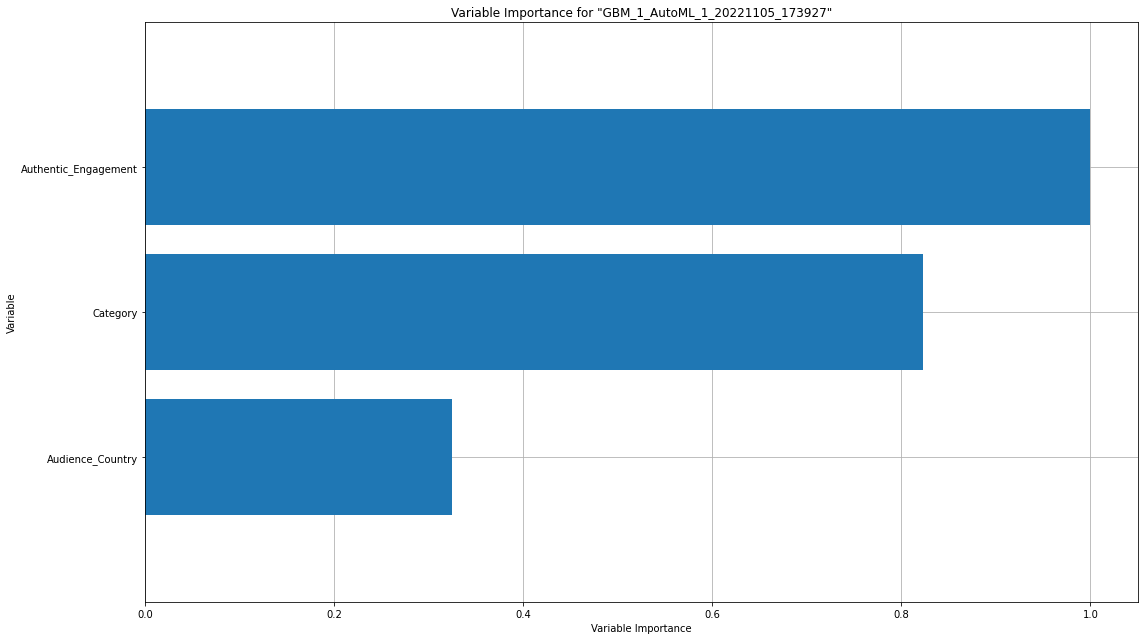

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

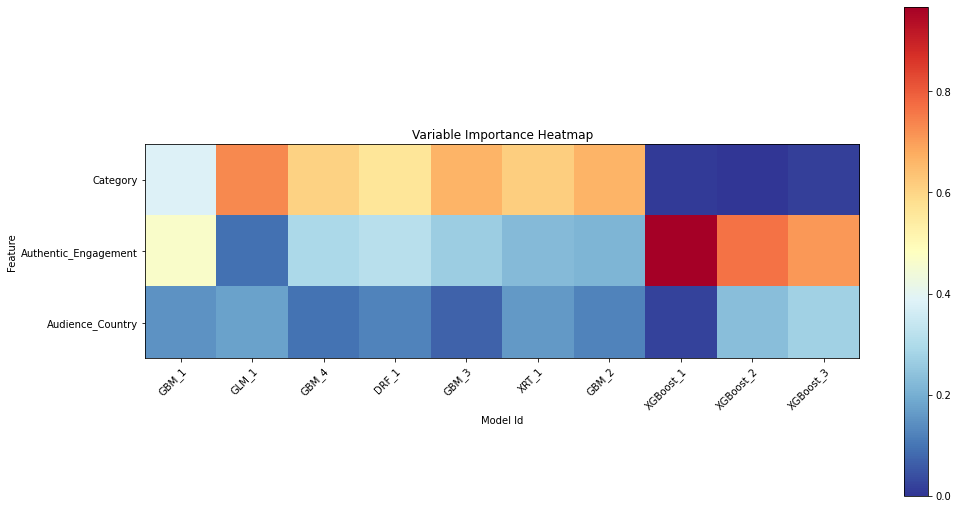

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

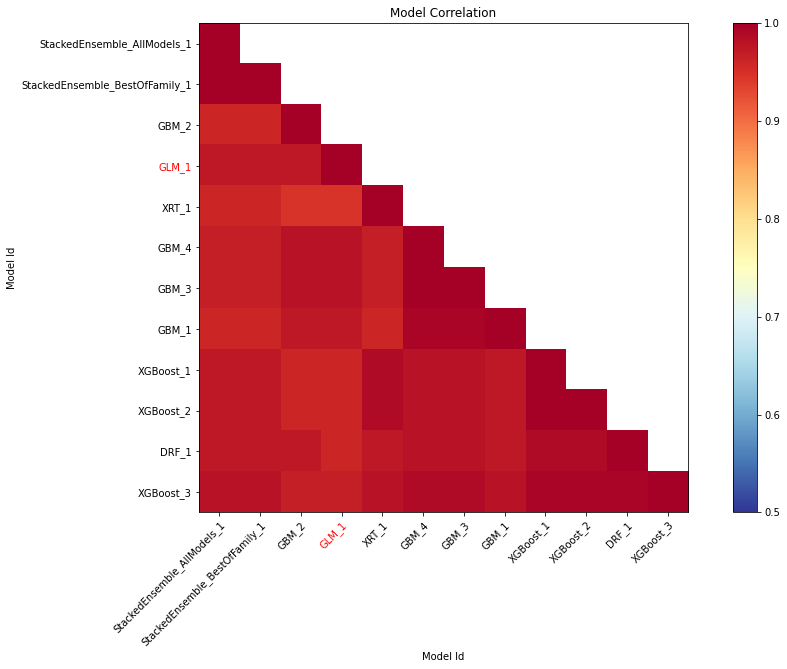

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

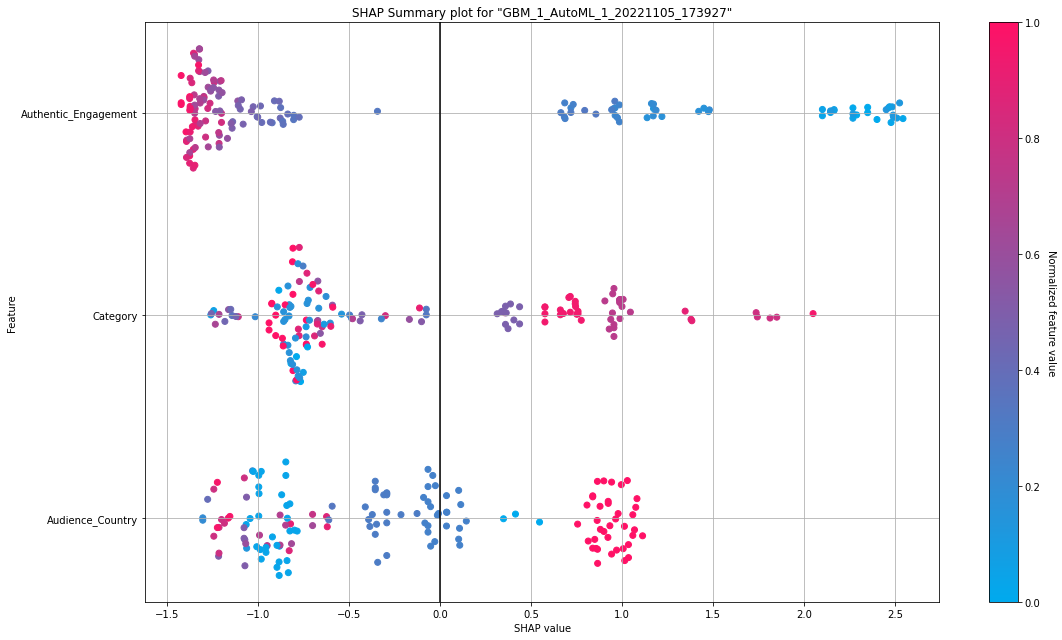

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

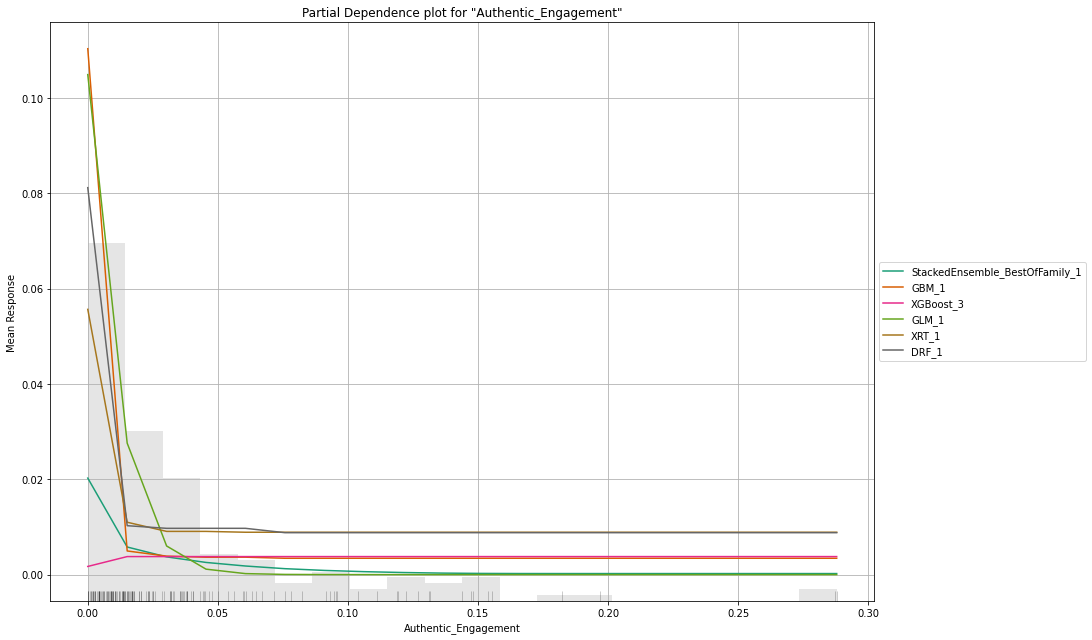

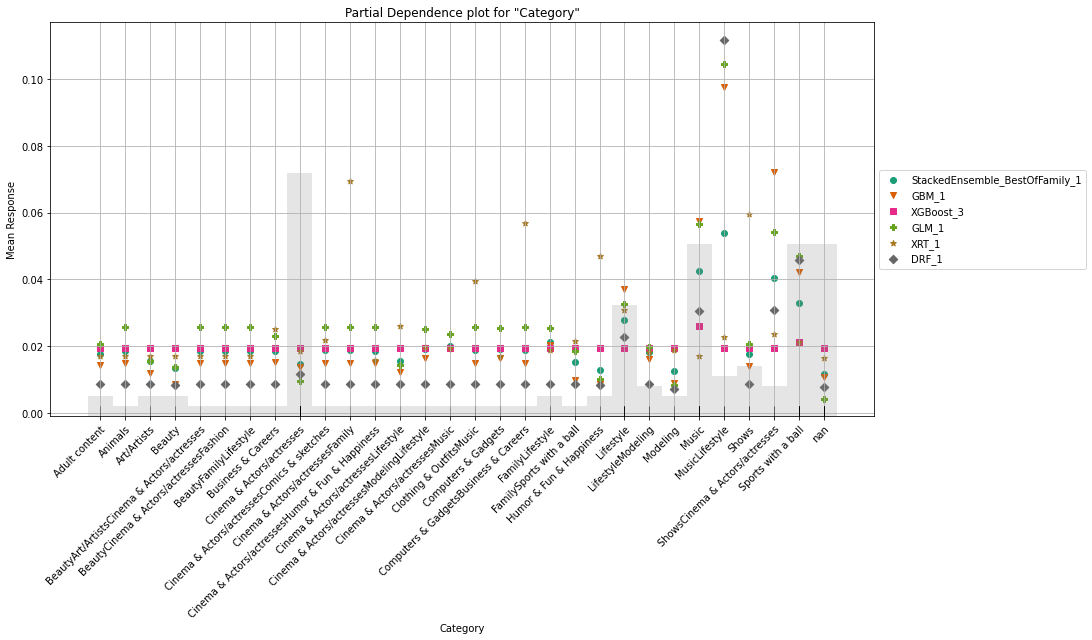

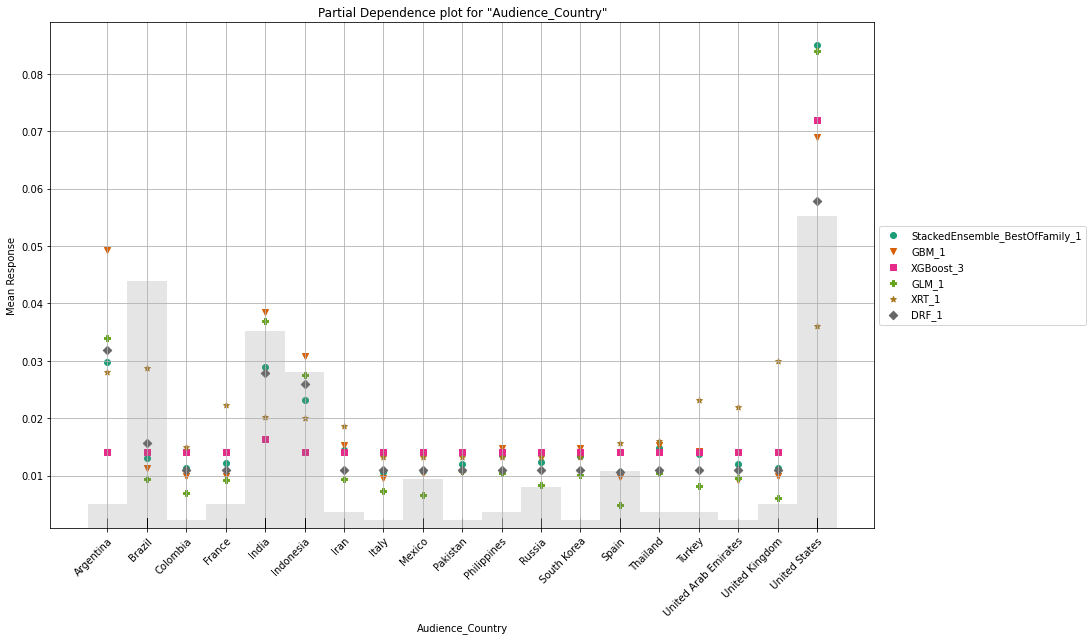

In [33]:
# Explain a model
aml.explain(test);


## Answer the following questions for all of the models:

**Is the relationship significant?**
    
    Authentic_Engagement,Engagement_Avg, Audience_Country_United,States,Category_Music
    P value of these colums are lower than 0.05
    so except Rank,relationship is significant

**Are any model assumptions violated?**
    
    because of multicolinearity of Authentic_Engagement and Engagement_Avg, it violated assumption of GLM. then I remove Engagement_Avg from the model.


**Is there any multicollinearity in the model?**

    from the pairplot, we can know that Rank, Followers,FollowersBigger100M, are  multicollinearity in the model.
    Authentic_Engagement,Engagement_Avg are multicollinearity in the model.

**In the multivariate models are predictor variables independent of all the other predictor variables?**

    I remove Rank, Followers,Authentic_Engagement before creating multivariate models. so for now ['Name', 'Category', 'Audience_Country', 'Engagement_Avg'] are independent of all the other predictor variables.

**In in multivariate models rank the most significant predictor variables and exclude insignificant ones from the model.**

    from the rank in the performance, we know the most significant predictor is Engagement_Avg and most insignificant one is Audience_Country

**Does the model make sense?**
    
    yes,all the model AUC about 0.9, and the lowest logloss reach 0.07 

**Does regularization help?**
    
         GLM																GLM_1_AutoML_1_20221104_03912
    MSE: 0.030837509318758713											MSE:0.0232598
    RMSE: 0.17560611982148774											 RMSE:0.152511
    LogLoss: 0.11841262805084014										LogLoss:0.0842035
    AUC: 0.9088130563798219												AUC:0.914414
    AUCPR: 0.3925992244037537											AUCPR:0.113196
    Gini: 0.8176261127596438											
    Null degrees of freedom: 698										
    Residual degrees of freedom: 694									
    Null deviance: 215.63375688966926									
    Residual deviance: 165.54085401507453								
    AIC: 175.54085401507453												
    
    in the left the training data of GLM is not regularized. 
    in the right side the training data is regularized.
    It is clear that regularization has had some effect in this experiment

**Which independent variables are significant?**

    Engagement_Avg
    Audience_Country.United States
    Category.Cinema & Actors/actresses	
    Category.Music
    these are significant independent variables

**Which hyperparameters are important?**

    for the GLM, alpha is important hyperparameter.
    For the XGBoost booster, col_sample_rate, col_sample_rate_per_tree, max_depth, min_rows, ntrees, reg_alpha, reg_lambda,sample_rate are important
    For the GBM , col_sample_rate,col_sample_rate_per_tree, learn_rate, max_depth,min_rows,min_split_improvement,ntrees, sample_rate are important.
    

# References

    Sckit learn offcial documentation

    Eli5 official documentation

    Refered Towards Data Science

    H2o.ai official documentation

    The algorithms were referred directly from the Sckit learn official documentation and h2o introduction. Visualization was referred from Tutorials in Matplotlab documentation. Feature importance reference is taken from eli5 offical documnetation. The remaining code was written independently.

    Copyright (c) 2022 Yu An

    Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

    The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

    THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.